# Problema 5

## **SER** e **BER** sobrepostas (M-QAM x M-PSK)

In [1]:
import numpy as np # for numerical computing
import matplotlib.pyplot as plt # for plotting functions
from matplotlib import cm # colormap for color palette
from scipy.special import erfc

In [2]:
# general, agnostic functions
def modulate(constellation,inputSymbols):
    modulatedVec = constellation[inputSymbols]
    return modulatedVec 

def demodulate(constellation,receivedSyms):
    # received vector and reference in cartesian form
    from scipy.spatial.distance import cdist
    XA = np.column_stack((np.real(receivedSyms),np.imag(receivedSyms)))
    XB = np.column_stack((np.real(constellation),np.imag(constellation)))
        
    d = cdist(XA,XB,metric='euclidean') #compute pair-wise Euclidean distances
    detectedSyms=np.argmin(d,axis=1)#indices corresponding minimum Euclid. dist.
    return detectedSyms

def awgn(s, SNRdB):
    gamma = 10**(SNRdB/10) #SNR to linear scale
    P=np.sum(abs(s)**2)/len(s) # power in the vector -> P=sum (X^{2})/M
    N0=P/gamma # noise spectral density
    n = np.sqrt(N0/2)*(np.random.randn(len(s)) + 1j*np.random.randn(len(s))) # AWGN with unity power
    r = s + n # received signal + noise
    return r

In [3]:
# M-QAM related
def QAMModem(M): # gray coding into constellation setup ahead
    n=np.arange(0,M) # symbols from 0 to M-1
    a=np.asarray([x^(x>>1) for x in n]) # convert linear to gray code
    D=np.sqrt(M).astype(int) # dimension of our map
    a=np.reshape(a,(D,D)) # slice array on a matrix D x D sized
    oddRows=np.arange(start=1,stop=D,step=2) # identify rows to flip
    a[oddRows,:]=np.fliplr(a[oddRows,:]) # flip the rows
    nGray=np.reshape(a,(M)) # reshape/flatten to 1xM array
    (x,y)=np.divmod(nGray,D) # element-wise quotient and remainder
    Ax=2*x+1-D
    Ay=2*y+1-D
    constellation = Ax + 1j*Ay
    return constellation

def qam_awgn(M,gamma_s):
    if (M==1) or (np.mod(np.log2(M),2)!=0): # M not a even power of 2
        raise ValueError('Only square MQAM supported. M must be even power of 2')
    SERs = 1-(1-(1-1/np.sqrt(M))*erfc(np.sqrt(3/2*gamma_s/(M-1))))**2
    return SERs

In [4]:
# M-PSK related
def PSKModem(M):
    #Generate reference constellation
    m = np.arange(0,M) #all information symbols m={0,1,...,M-1}
    I = 1/np.sqrt(2)*np.cos(m/M*2*np.pi)
    Q = 1/np.sqrt(2)*np.sin(m/M*2*np.pi)
    constellation = I + 1j*Q #reference constellation
    return constellation

def psk_awgn(M,gamma_s):
    gamma_b = gamma_s/np.log2(M)
    if (M==2):
        SERs = 0.5*erfc(np.sqrt(gamma_b))
    elif M==4:
        Q = 0.5*erfc(np.sqrt(gamma_b))
        SERs = 2*Q-Q**2
    else:
        SERs = erfc(np.sqrt(gamma_s)*np.sin(np.pi/M))
    return SERs

# **SER**

(1e-06, 1)

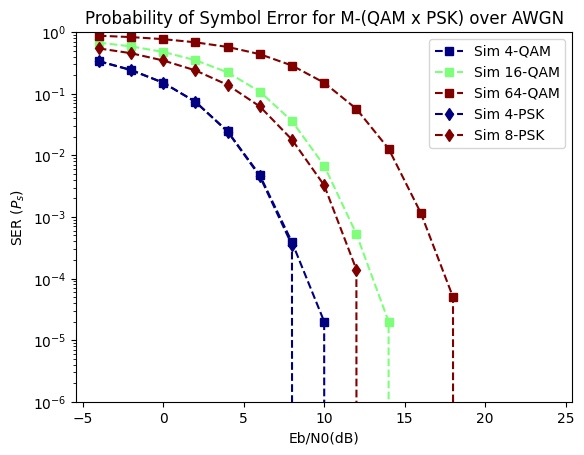

In [5]:
#---------Input Fields------------------------
nSym = 10**5 # Number of symbols to transmit # also, compile time for 10**6 is over 30s. for a quicker result do either 10**5 or 10**4
EbN0dBs = np.arange(start=-4,stop = 26, step = 2) # Eb/N0 range in dB for simulation
mod_type = 'QAM'
arrayOfM=[4,16,64]#,256] 

colors = plt.cm.jet(np.linspace(0,1,len(arrayOfM))) # colormap
fig, ax = plt.subplots(nrows=1,ncols = 1)

for i, M in enumerate(arrayOfM):
    #-----Initialization of various parameters----
    k=np.log2(M)
    EsN0dBs = 10*np.log10(k)+EbN0dBs # EsN0dB calculation
    SER_sim = np.zeros(len(EbN0dBs)) # simulated Symbol error rates
    inputSyms = np.random.randint(low=0, high = M, size=nSym) # uniform random symbols from 0 to M-1
    
    constellation = QAMModem(M)
    modulatedSyms = modulate(constellation,inputSyms) #modulate

    for j,EsN0dB in enumerate(EsN0dBs):
        receivedSyms = awgn(modulatedSyms,EsN0dB) #add awgn noise
        detectedSyms = demodulate(constellation,receivedSyms)
        
        SER_sim[j] = np.sum(detectedSyms != inputSyms)/nSym
    
    
    ax.semilogy(EbN0dBs,SER_sim,color = colors[i],marker='s',linestyle='--',label='Sim '+str(M)+'-'+mod_type.upper())
    # in case you want to see the theoretical values plotted as well, uncomment the following lines:
    #gamma_s = np.log2(M)*(10**(EbN0dBs/10))
    #SER_theory = qam_awgn(M,gamma_s) #theory SER
    #ax.semilogy(EbN0dBs,SER_theory,color = colors[i],linestyle='-',label='Theory, '+str(M)+'-'+mod_type.upper())


mod_type = 'PSK'
arrayOfM = [4,8] # [2,4,8,16,32]

colors = plt.cm.jet(np.linspace(0,1,len(arrayOfM))) # colormap
#fig, ax = plt.subplots(nrows=1,ncols = 1)

for i, M in enumerate(arrayOfM):
    #-----Initialization of various parameters----
    k=np.log2(M)
    EsN0dBs = 10*np.log10(k)+EbN0dBs # EsN0dB calculation
    SER_sim = np.zeros(len(EbN0dBs)) # simulated Symbol error rates
    inputSyms = np.random.randint(low=0, high = M, size=nSym) # uniform random symbols from 0 to M-1
    
    constellation = PSKModem(M)
    modulatedSyms = modulate(constellation,inputSyms) #modulate

    for j,EsN0dB in enumerate(EsN0dBs):
        receivedSyms = awgn(modulatedSyms,EsN0dB) #add awgn noise
        detectedSyms = demodulate(constellation,receivedSyms)
        
        SER_sim[j] = np.sum(detectedSyms != inputSyms)/nSym
    
    
    ax.semilogy(EbN0dBs,SER_sim,color = colors[i],marker='d',linestyle='--',label='Sim '+str(M)+'-'+mod_type.upper())
    # in case you want to see the theoretical values plotted as well, uncomment the following lines:
    #gamma_s = np.log2(M)*(10**(EbN0dBs/10))
    #SER_theory = psk_awgn(M,gamma_s) #theory SER
    #ax.semilogy(EbN0dBs,SER_theory,color = colors[i],linestyle='-',label='Theory, '+str(M)+'-'+mod_type.upper())

ax.set_xlabel('Eb/N0(dB)')
ax.set_ylabel('SER ($P_s$)')
ax.set_title('Probability of Symbol Error for M-(QAM x PSK) over AWGN')
ax.legend()
ax.set_ylim(1e-6,1) # if you don't set the limit it will get goofy. leave this untouched.

## **BER**

(1e-06, 1)

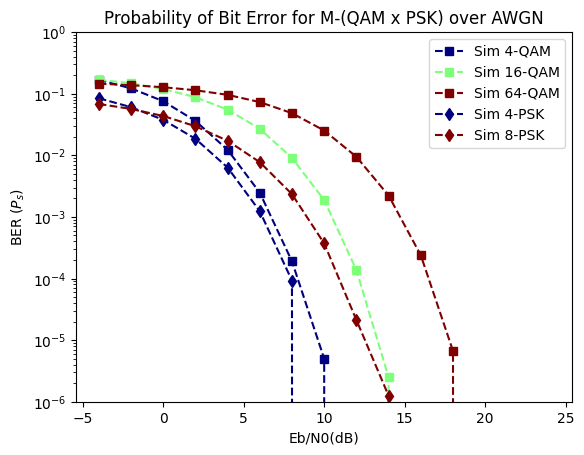

In [6]:
#---------Input Fields------------------------
nSym = 10**5 # Number of symbols to transmit # also, compile time for 10**6 is over 30s. for a quicker result do either 10**5 or 10**4
EbN0dBs = np.arange(start=-4,stop = 26, step = 2) # Eb/N0 range in dB for simulation
mod_type = 'QAM'
arrayOfM=[4,16,64]#,256] 

colors = plt.cm.jet(np.linspace(0,1,len(arrayOfM))) # colormap
fig, ax = plt.subplots(nrows=1,ncols = 1)

for i, M in enumerate(arrayOfM):
    #-----Initialization of various parameters----
    k=np.log2(M)
    EsN0dBs = 10*np.log10(k)+EbN0dBs # EsN0dB calculation
    SER_sim = np.zeros(len(EbN0dBs)) # simulated Symbol error rates
    inputSyms = np.random.randint(low=0, high = M, size=nSym) # uniform random symbols from 0 to M-1
    
    constellation = QAMModem(M)
    modulatedSyms = modulate(constellation,inputSyms) #modulate

    for j,EsN0dB in enumerate(EsN0dBs):
        receivedSyms = awgn(modulatedSyms,EsN0dB) #add awgn noise
        detectedSyms = demodulate(constellation,receivedSyms)
        
        SER_sim[j] = np.sum(detectedSyms != inputSyms)/nSym
    
    
    ax.semilogy(EbN0dBs,SER_sim/k,color = colors[i],marker='s',linestyle='--',label='Sim '+str(M)+'-'+mod_type.upper())
    # in case you want to see the theoretical values plotted as well, uncomment the following lines:
    #gamma_s = np.log2(M)*(10**(EbN0dBs/10))
    #SER_theory = qam_awgn(M,gamma_s) #theory SER
    #ax.semilogy(EbN0dBs,SER_theory/k,color = colors[i],linestyle='-',label='Theory, '+str(M)+'-'+mod_type.upper())


mod_type = 'PSK'
arrayOfM = [4,8] # [2,4,8,16,32]

colors = plt.cm.jet(np.linspace(0,1,len(arrayOfM))) # colormap
#fig, ax = plt.subplots(nrows=1,ncols = 1)

for i, M in enumerate(arrayOfM):
    #-----Initialization of various parameters----
    k=np.log2(M)
    EsN0dBs = 10*np.log10(k)+EbN0dBs # EsN0dB calculation
    SER_sim = np.zeros(len(EbN0dBs)) # simulated Symbol error rates
    inputSyms = np.random.randint(low=0, high = M, size=nSym) # uniform random symbols from 0 to M-1
    
    constellation = PSKModem(M)
    modulatedSyms = modulate(constellation,inputSyms) #modulate

    for j,EsN0dB in enumerate(EsN0dBs):
        receivedSyms = awgn(modulatedSyms,EsN0dB) #add awgn noise
        detectedSyms = demodulate(constellation,receivedSyms)
        
        SER_sim[j] = np.sum(detectedSyms != inputSyms)/nSym
    
    
    ax.semilogy(EbN0dBs,SER_sim/M,color = colors[i],marker='d',linestyle='--',label='Sim '+str(M)+'-'+mod_type.upper())
    # in case you want to see the theoretical values plotted as well, uncomment the following lines:
    #gamma_s = np.log2(M)*(10**(EbN0dBs/10))
    #SER_theory = psk_awgn(M,gamma_s) #theory SER
    #ax.semilogy(EbN0dBs,SER_theory/M,color = colors[i],linestyle='-',label='Theory, '+str(M)+'-'+mod_type.upper())

ax.set_xlabel('Eb/N0(dB)')
ax.set_ylabel('BER ($P_s$)')
ax.set_title('Probability of Bit Error for M-(QAM x PSK) over AWGN')
ax.legend()
ax.set_ylim(1e-6,1) # if you don't set the limit it will get goofy. leave this untouched.

## Discussão de resultados

Para os sinais PSK, plotar o gráfico da SER ($P_{s}$) vai nos mostrar que esse tipo de modulação sofre uma penalidade muito grande na SNR nos casos em que $M$ é maior que $M=4$. Aqui não podemos ver isso muito bem, pois só temos dois casos, mas isso se torna mais visível quando incluímos outros casos (como visto nos problemas anteriores). De qualquer forma, para valores grandes de $M$, percebe-se que dobrar o número de fases requer cerca de $6dB/bit$ para obter a mesma performance.

Já para o caso dos sinais em QAM, a penalidade por aumentar a constelação é bem menor e mais consistente (cerca de $3dB/bit$), mostrando que a modulação QAM é mais eficiente no quesito energético quando comparado a modulação PSK.

No final das contas, a grande vantagem da modulação PSK é que é uma modulação que tem [constant-envelope properties], ou seja, a amplitude é constante.